In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


# ===============================
# 1. Data Preprocessing
# ===============================<>

In [ ]:
# Load the dataset
data_path = "DataSet_4_Exam/AirQualityUCI.csv"
data = pd.read_csv(data_path, sep=';', decimal=',', na_values=-200)

# Remove the last two columns (empty)
data = data.iloc[:, :-2]

# Combine Date and Time into DateTime
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S')

# Set DateTime as the index
data.set_index('DateTime', inplace=True)

# Select columns
df = data[['CO(GT)', 'NO2(GT)', 'RH']]

print(df.isna().sum().sum()) # checking NaN numbers

# Drop NaN
df.dropna(inplace=True)


4033


In [ ]:
print(df.index.freq)

None


In [19]:
df = df.asfreq('H')
print(df.isna().sum().sum()) # checking NaN numbers
df.dropna(inplace=True)

# Ensure DateTime index is of datetime type
df.index = pd.to_datetime(df.index)

# Convert data types to float
df = df.astype(float)

7248


# ===============================
# 2. Exploratory Data Analysis
# ===============================

In [3]:
# Display the first few rows after preprocessing
print("Preprocessed Data:")
print(df.head())

Preprocessed Data:
                     CO(GT)  NO2(GT)    RH
DateTime                                  
2004-03-10 18:00:00     2.6    113.0  48.9
2004-03-10 19:00:00     2.0     92.0  47.7
2004-03-10 20:00:00     2.2    114.0  54.0
2004-03-10 21:00:00     2.2    122.0  60.0
2004-03-10 22:00:00     1.6    116.0  59.6


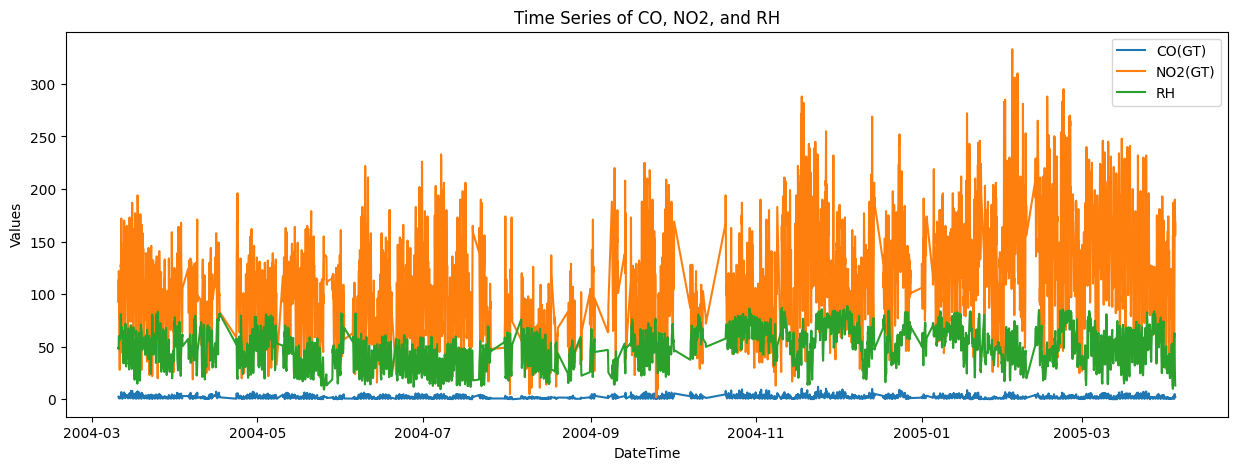

In [4]:
# Plot the time series
plt.figure(figsize=(15,5))
plt.plot(df)
plt.title('Time Series of CO, NO2, and RH')
plt.xlabel('DateTime')
plt.ylabel('Values')
plt.legend(['CO(GT)', 'NO2(GT)', 'RH'])
plt.show()


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

# List of variable pairs to test
variable_pairs = [('CO(GT)', 'NO2(GT)'),
                  ('CO(GT)', 'RH'),
                  ('NO2(GT)', 'CO(GT)'),
                  ('NO2(GT)', 'RH'),
                  ('RH', 'CO(GT)'),
                  ('RH', 'NO2(GT)')]

# Maximum number of lags
max_lag = 5

# Perform Granger Causality tests for all pairs
for x, y in variable_pairs:
    print(f"Testing if {x} Granger-causes {y}")
    results = grangercausalitytests(df[[x, y]], maxlag=max_lag, verbose=False)
    for lag, result in results.items():
        p_value = result[0]['ssr_ftest'][1]
        print(f"Lag {lag} p-value: {p_value:.5f}")
    print("\n")


Testing if CO(GT) Granger-causes NO2(GT)
Lag 1 p-value: 0.03219
Lag 2 p-value: 0.00000
Lag 3 p-value: 0.00000
Lag 4 p-value: 0.00000
Lag 5 p-value: 0.00000


Testing if CO(GT) Granger-causes RH
Lag 1 p-value: 0.16587
Lag 2 p-value: 0.29038
Lag 3 p-value: 0.00264
Lag 4 p-value: 0.00511
Lag 5 p-value: 0.00000


Testing if NO2(GT) Granger-causes CO(GT)
Lag 1 p-value: 0.00271
Lag 2 p-value: 0.00000
Lag 3 p-value: 0.00000
Lag 4 p-value: 0.00000
Lag 5 p-value: 0.00000


Testing if NO2(GT) Granger-causes RH
Lag 1 p-value: 0.55955
Lag 2 p-value: 0.03950
Lag 3 p-value: 0.07579
Lag 4 p-value: 0.01889
Lag 5 p-value: 0.00002


Testing if RH Granger-causes CO(GT)
Lag 1 p-value: 0.05055
Lag 2 p-value: 0.00000
Lag 3 p-value: 0.00000
Lag 4 p-value: 0.00000
Lag 5 p-value: 0.00000


Testing if RH Granger-causes NO2(GT)
Lag 1 p-value: 0.15654
Lag 2 p-value: 0.00000
Lag 3 p-value: 0.00000
Lag 4 p-value: 0.00000
Lag 5 p-value: 0.00000




Correlation Matrix:
           CO(GT)   NO2(GT)        RH
CO(GT)   1.000000  0.673840  0.064753
NO2(GT)  0.673840  1.000000 -0.075333
RH       0.064753 -0.075333  1.000000


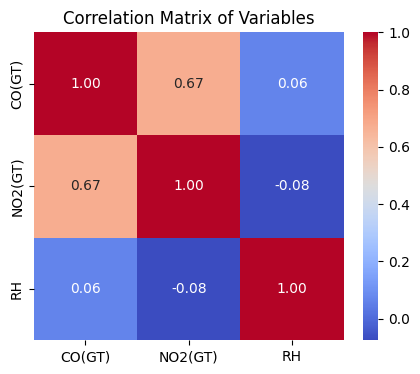

In [ ]:
correlation_matrix = df.corr()

print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Variables')
plt.show()


In [7]:
# Check for stationarity using Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'ADF Test: {title}')
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("=> The series is stationary.\n")
    else:
        print("=> The series is non-stationary.\n")

for column in df.columns:
    adf_test(df[column], title=column)

ADF Test: CO(GT)
ADF Statistic            -9.894641e+00
p-value                   3.484035e-17
#Lags Used                3.200000e+01
Number of Observations    6.908000e+03
Critical Value (1%)      -3.431297e+00
Critical Value (5%)      -2.861958e+00
Critical Value (10%)     -2.566993e+00
=> The series is stationary.

ADF Test: NO2(GT)
ADF Statistic            -7.223010e+00
p-value                   2.087551e-10
#Lags Used                3.200000e+01
Number of Observations    6.908000e+03
Critical Value (1%)      -3.431297e+00
Critical Value (5%)      -2.861958e+00
Critical Value (10%)     -2.566993e+00
=> The series is stationary.

ADF Test: RH
ADF Statistic            -7.399081e+00
p-value                   7.639367e-11
#Lags Used                2.400000e+01
Number of Observations    6.916000e+03
Critical Value (1%)      -3.431296e+00
Critical Value (5%)      -2.861958e+00
Critical Value (10%)     -2.566992e+00
=> The series is stationary.



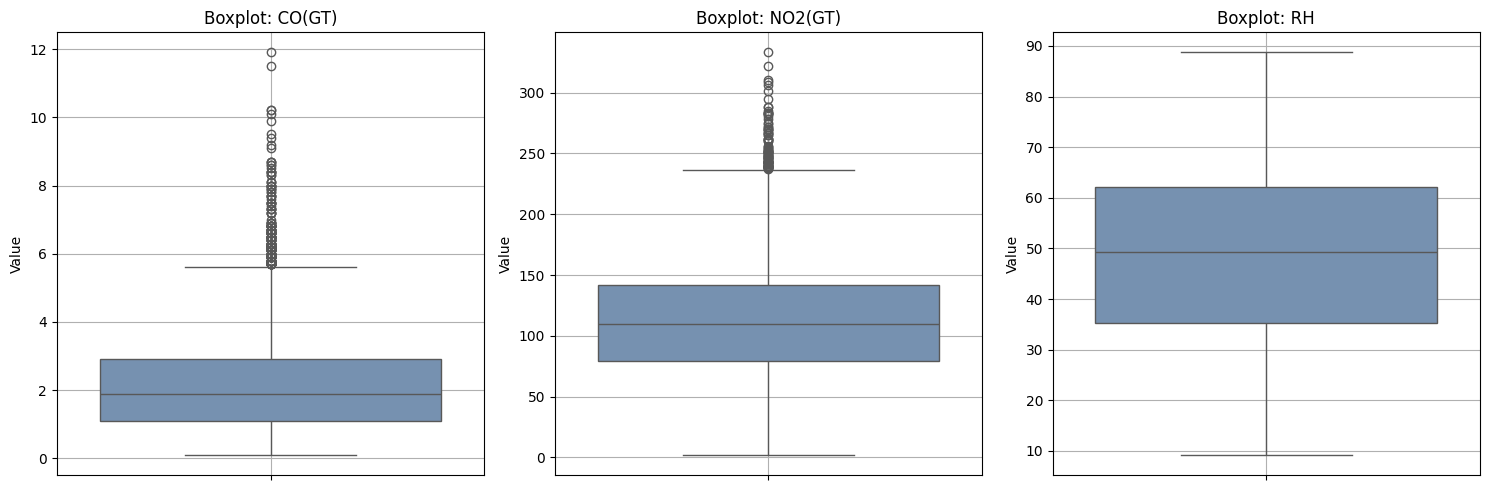

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot for each variable in the original df
plt.figure(figsize=(15, 5))

for i, var in enumerate(df.columns, start=1):
    plt.subplot(1, len(df.columns), i)  # Create a subplot for each variable
    sns.boxplot(y=df[var], color='#6D90B9')
    plt.title(f'Boxplot: {var}')
    plt.ylabel('Value')
    plt.grid(True)

plt.tight_layout()
plt.show()


# ===============================
# 3. Data Splitting and Scaling 
# ===============================

Training set size: 5899
Test set size: 1042

Checking for NaNs in scaled training data:
CO(GT)     0
NO2(GT)    0
RH         0
dtype: int64

Checking for NaNs in scaled testing data:
CO(GT)     0
NO2(GT)    0
RH         0
dtype: int64


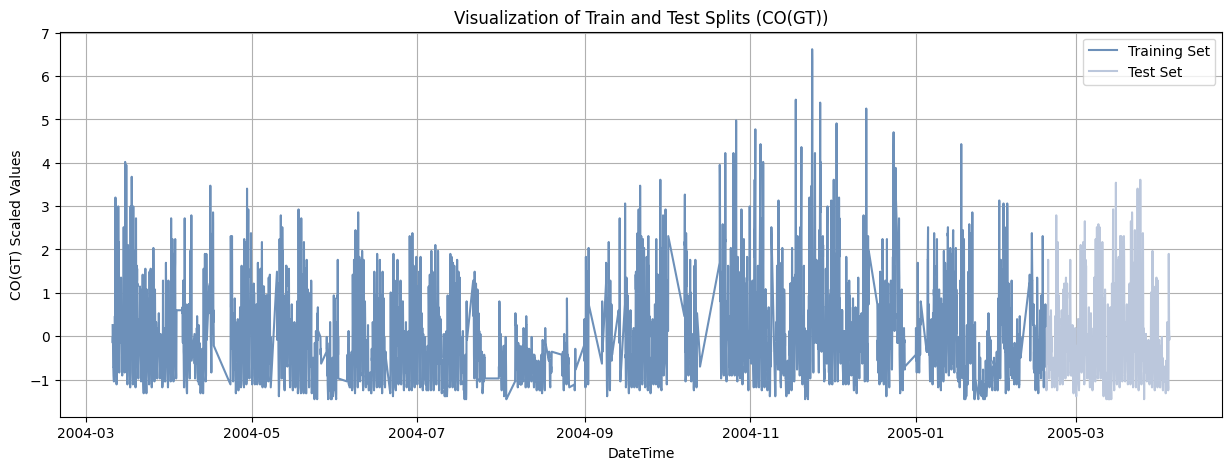

In [ ]:
# Split the data into train and test
train_size = int(len(df) * 0.85)  # 85% training
test_size = len(df) - train_size   # 15% testing

# Create the splits
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

print("Training set size:", len(train))
print("Test set size:", len(test))

# Initialize separate scalers for each variable
scalers = {}
for var in df.columns:
    scalers[var] = StandardScaler()
    scalers[var].fit(train[[var]])
    train[var + '_scaled'] = scalers[var].transform(train[[var]])
    test[var + '_scaled'] = scalers[var].transform(test[[var]])

# create scaled DataFrames
train_scaled = train[[var + '_scaled' for var in df.columns]].copy()
test_scaled = test[[var + '_scaled' for var in df.columns]].copy()
train_scaled.columns = df.columns
test_scaled.columns = df.columns

# Verify no NaNs in scaled data
print("\nChecking for NaNs in scaled training data:")
print(train_scaled.isna().sum())
print("\nChecking for NaNs in scaled testing data:")
print(test_scaled.isna().sum())

# Plot the splits for CO(GT) data
plt.figure(figsize=(15, 5))

# Plot the training set in blue
plt.plot(train_scaled.index, train_scaled['CO(GT)'], label='Training Set', color='#6D90B9')

# Plot the test set in green
plt.plot(test_scaled.index, test_scaled['CO(GT)'], label='Test Set', color='#BBC7DC')

plt.title('Visualization of Train and Test Splits (CO(GT))')
plt.xlabel('DateTime')
plt.ylabel('CO(GT) Scaled Values')
plt.legend()
plt.grid(True)

plt.show()

# ===============================
# 4. Model Implementation: SARIMAX
# ===============================

In [10]:
# Define the target variables
target_vars = ['CO(GT)', 'NO2(GT)', 'RH']

In [ ]:
crash, to make sure the next box isnt ran by accident.

In [ ]:
import itertools
from joblib import Parallel, delayed
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# Global dictionary to store best parameters
best_sarimax_parameters = {}

def fit_model_combination(order, seasonal_order, train_scaled, var, target_vars):
    try:
        # Ensure exogenous variables exclude the target variable
        exog_vars = [v for v in target_vars if v != var]

        # Fit SARIMAX model
        model = SARIMAX(
            train_scaled[var],
            exog=train_scaled[exog_vars] if exog_vars else None,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        return (results.aic, order, seasonal_order)

    except Exception as e:
        return (None, order, seasonal_order, str(e))


def grid_search_for_variable(train_scaled, var, target_vars, p_list, d_list, q_list, P_list, D_list, Q_list, s):
    """
    Perform grid search for a single variable to find the best SARIMAX parameters.
    """
    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None

    combinations = list(itertools.product(p_list, d_list, q_list, P_list, D_list, Q_list))

    results = Parallel(n_jobs=12)(
        delayed(fit_model_combination)(
            (p, d, q),
            (P, D, Q, s),
            train_scaled,
            var,
            target_vars
        )
        for p, d, q, P, D, Q in tqdm(combinations, desc=f"Testing SARIMAX combinations for {var}")
    )

    for result in results:
        if result[0] is not None:  # Valid AIC value
            aic, order, seasonal_order = result[:3]
            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_seasonal_order = seasonal_order
        else:
            _, order, seasonal_order, error = result
            print(f"Error with combination {order} and {seasonal_order} for {var}: {error}")

    print(f"Best AIC for {var}: {best_aic}")
    print(f"Best (p,d,q) for {var}: {best_order}")
    print(f"Best (P,D,Q,s) for {var}: {best_seasonal_order}")

    return {
        "variable": var,
        "aic": best_aic,
        "p_value": best_order[0] if best_order else None,
        "d_value": best_order[1] if best_order else None,
        "q_value": best_order[2] if best_order else None,
        "P_value": best_seasonal_order[0] if best_seasonal_order else None,
        "D_value": best_seasonal_order[1] if best_seasonal_order else None,
        "Q_value": best_seasonal_order[2] if best_seasonal_order else None,
        "s_value": best_seasonal_order[3] if best_seasonal_order else None,
    }


def grid_search_for_all_variables(train_scaled, target_vars, p_list, d_list, q_list, P_list, D_list, Q_list, s):
    """
    Perform grid search for all target variables and find the best parameters for each.
    """
    global best_sarimax_parameters
    best_params = []

    for var in target_vars:
        print(f"\nStarting grid search for {var}...")
        best_param = grid_search_for_variable(train_scaled, var, target_vars, p_list, d_list, q_list, P_list, D_list, Q_list, s)
        best_params.append(best_param)
        best_sarimax_parameters[var] = best_param

    return pd.DataFrame(best_params)


if __name__ == "__main__":
    target_vars = ["CO(GT)", "NO2(GT)", "RH"]  # Variables
    p_list = [1, 2, 3]
    d_list = [0, 1]
    q_list = [1, 2, 3]
    P_list = [1, 2, 3]
    D_list = [0, 1]
    Q_list = [1, 2, 3]
    s = 24

    # Perform grid search
    best_parameters = grid_search_for_all_variables(train_scaled, target_vars, p_list, d_list, q_list, P_list, D_list, Q_list, s)

    # Display results
    print("\nBest parameters for each variable:")
    print(best_parameters)

    # Save results
    best_parameters.to_csv("best_sarimax_parameters.csv", index=False)



Starting grid search for CO(GT)...


Testing SARIMAX combinations for CO(GT): 100%|██████████| 324/324 [2:02:16<00:00, 22.64s/it]


Best AIC for CO(GT): 5361.782419688838
Best (p,d,q) for CO(GT): (2, 0, 3)
Best (P,D,Q,s) for CO(GT): (3, 0, 1, 24)

Starting grid search for NO2(GT)...


Testing SARIMAX combinations for NO2(GT): 100%|██████████| 324/324 [1:35:37<00:00, 17.71s/it]


Best AIC for NO2(GT): 3154.686613263607
Best (p,d,q) for NO2(GT): (2, 0, 3)
Best (P,D,Q,s) for NO2(GT): (3, 0, 1, 24)

Starting grid search for RH...


Testing SARIMAX combinations for RH: 100%|██████████| 324/324 [1:25:26<00:00, 15.82s/it]


Best AIC for RH: 49.14150906123044
Best (p,d,q) for RH: (3, 1, 3)
Best (P,D,Q,s) for RH: (1, 0, 1, 24)

Best parameters for each variable:
  variable          aic  p_value  d_value  q_value  P_value  D_value  Q_value  \
0   CO(GT)  5361.782420        2        0        3        3        0        1   
1  NO2(GT)  3154.686613        2        0        3        3        0        1   
2       RH    49.141509        3        1        3        1        0        1   

   s_value  
0       24  
1       24  
2       24  


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load best parameters
best_sarimax_parameters = pd.read_csv("best_sarimax_parameters.csv").set_index("variable").to_dict(orient="index")

def sarimax_forecast(train, test, target, exog=None):
    # Fetch best parameters for each variable
    params = best_sarimax_parameters.get(target)
    if not params:
        raise ValueError(f"No parameters found for target variable: {target}")
    
    # Extract orders from the parameters
    order = (params['p_value'], params['d_value'], params['q_value'])
    seasonal_order = (params['P_value'], params['D_value'], params['Q_value'], params['s_value'])
    
    # Fit SARIMAX model
    model = SARIMAX(train, 
                    exog=exog, 
                    order=order, 
                    seasonal_order=seasonal_order, 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    
    # Forecast
    if exog is not None:
        forecast = model_fit.predict(start=test.index[0], end=test.index[-1], exog=exog)
    else:
        forecast = model_fit.predict(start=test.index[0], end=test.index[-1])
    
    return model_fit, forecast


# ===============================
# 5. Modeling Each Variable with SARIMAX
# ===============================


--- Modeling CO(GT) ---
                                      SARIMAX Results                                       
Dep. Variable:                               CO(GT)   No. Observations:                 5899
Model:             SARIMAX(2, 0, 3)x(3, 0, [1], 24)   Log Likelihood               -2714.955
Date:                              Sun, 08 Dec 2024   AIC                           5453.909
Time:                                      22:05:11   BIC                           5534.100
Sample:                                           0   HQIC                          5481.781
                                             - 5899                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
NO2(GT)        0.8555      0.007    126.761      0.000       0.842       

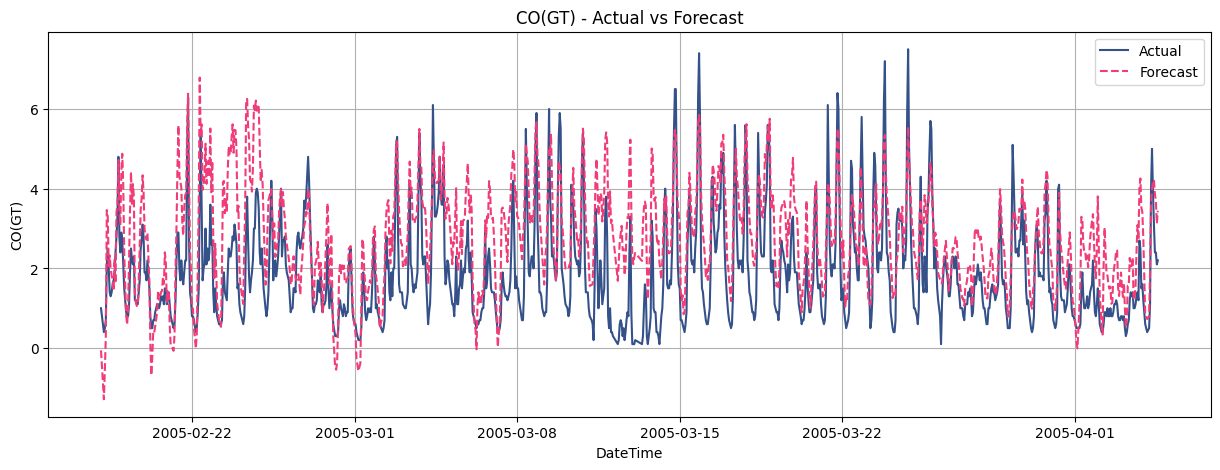


--- Modeling NO2(GT) ---
                                      SARIMAX Results                                       
Dep. Variable:                              NO2(GT)   No. Observations:                 5899
Model:             SARIMAX(2, 0, 3)x(3, 0, [1], 24)   Log Likelihood               -1580.973
Date:                              Sun, 08 Dec 2024   AIC                           3185.947
Time:                                      22:07:44   BIC                           3266.137
Sample:                                           0   HQIC                          3213.818
                                             - 5899                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CO(GT)         0.5672      0.005    106.584      0.000       0.557      

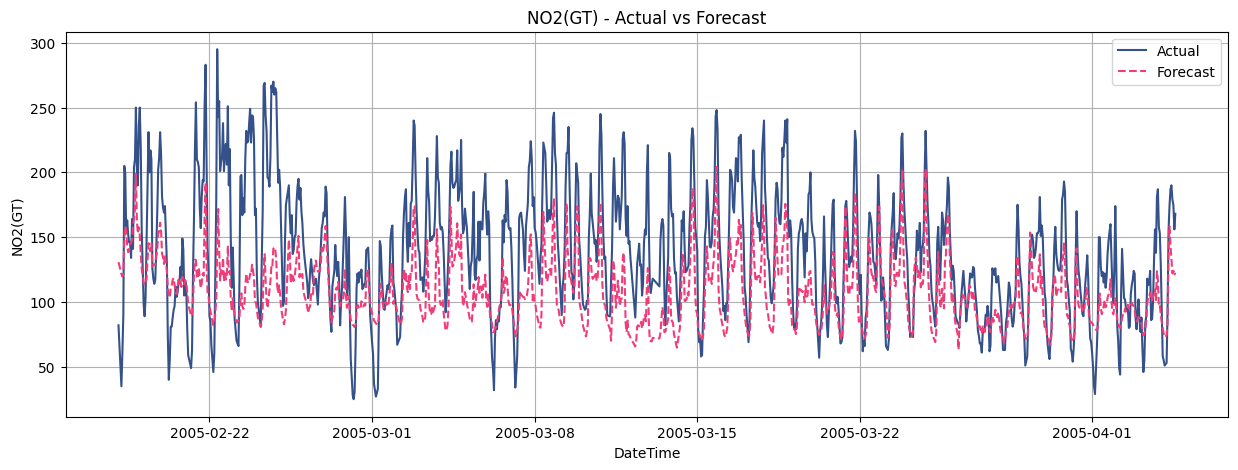


--- Modeling RH ---
                                      SARIMAX Results                                       
Dep. Variable:                                   RH   No. Observations:                 5899
Model:             SARIMAX(3, 1, 3)x(1, 0, [1], 24)   Log Likelihood                 -86.286
Date:                              Sun, 08 Dec 2024   AIC                            194.572
Time:                                      22:08:04   BIC                            268.078
Sample:                                           0   HQIC                           220.120
                                             - 5899                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CO(GT)         0.0768      0.006     12.102      0.000       0.064       0.08

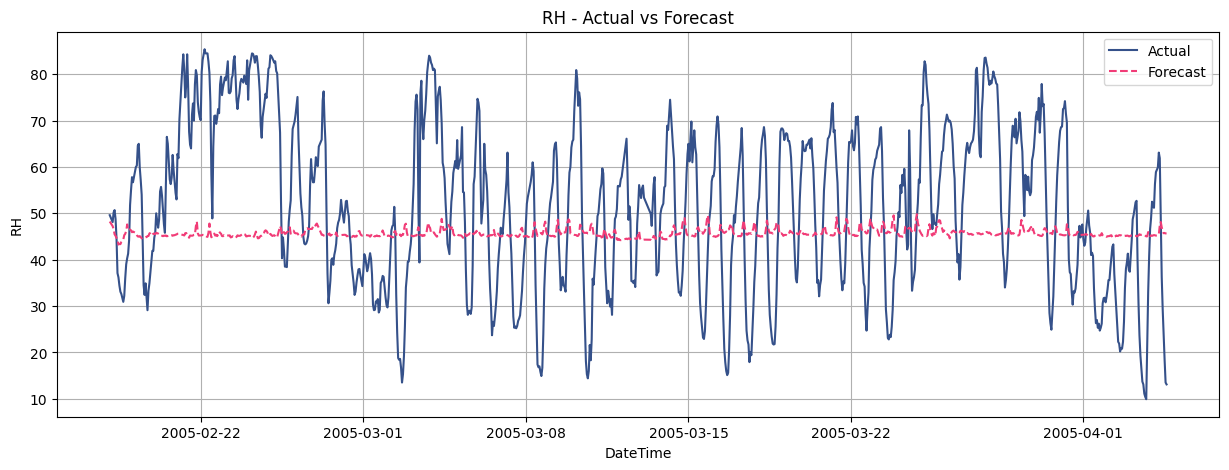

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load best parameters
best_sarimax_parameters = pd.read_csv("best_sarimax_parameters.csv").set_index("variable").to_dict(orient="index")

models = {}
forecasts = {}
metrics = {}

# Iterate over each variable
for var in target_vars:
    print(f"\n--- Modeling {var} ---")

    # Define SARIMAX orders
    params = best_sarimax_parameters.get(var)
    if not params:
        print(f"Skipping {var}: No SARIMAX parameters found.")
        continue

    sarimax_order = (params['p_value'], params['d_value'], params['q_value'])
    sarimax_seasonal_order = (params['P_value'], params['D_value'], params['Q_value'], params['s_value'])

    # Define target and exogenous variables
    target_train = train_scaled[var]
    target_test = test_scaled[var]

    # Exogenous variables: all other variables except the target
    exog_vars = [v for v in target_vars if v != var]
    exog_train = train_scaled[exog_vars]
    exog_test = test_scaled[exog_vars]

    # Fit the SARIMAX model
    try:
        model = SARIMAX(
            endog=target_train,
            exog=exog_train,
            order=sarimax_order,
            seasonal_order=sarimax_seasonal_order,
            enforce_stationarity=True,
            enforce_invertibility=True
        )
        
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
    except Exception as e:
        print(f"Error fitting SARIMAX for {var}: {e}")
        continue

    # Forecast
    try:
        # Use get_forecast to forecast beyond the training data
        forecast_obj = model_fit.get_forecast(steps=len(test_scaled), exog=exog_test)
        forecast = forecast_obj.predicted_mean

        # Align the forecast index with the test set
        forecast.index = test_scaled.index
    except Exception as e:
        print(f"Error during forecasting for {var}: {e}")
        continue

    # Inverse transform the forecasts and actuals
    try:
        forecast_inv = scalers[var].inverse_transform(forecast.values.reshape(-1, 1)).flatten()
        actual_inv = scalers[var].inverse_transform(test_scaled[var].values.reshape(-1, 1)).flatten()
    except Exception as e:
        print(f"Error in inverse transform for {var}: {e}")
        continue

    # Check for NaNs in forecasts and actuals
    print("NaNs in forecast_inv:", np.isnan(forecast_inv).sum())
    print("NaNs in actual_inv:", np.isnan(actual_inv).sum())

    # Store the model and forecasts
    models[var] = model_fit
    forecasts[var] = forecast_inv

    # Evaluate the forecast
    try:
        rmse = np.sqrt(mean_squared_error(actual_inv, forecast_inv))
        mae = mean_absolute_error(actual_inv, forecast_inv)
        metrics[var] = {'RMSE': rmse, 'MAE': mae}
        print(f"{var} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    except Exception as e:
        print(f"Error calculating metrics for {var}: {e}")
        continue

    # Plot the results
    try:
        plt.figure(figsize=(15, 5))
        plt.plot(test.index, actual_inv, label='Actual', color='#35518A')
        plt.plot(test.index, forecast_inv, label='Forecast', color='#F13C77', linestyle='--')
        plt.title(f'{var} - Actual vs Forecast')
        plt.xlabel('DateTime')
        plt.ylabel(var)
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Error during plotting for {var}: {e}")


# ===============================
# 6. Plotting the Results
# ===============================

In [ ]:
from sklearn.preprocessing import StandardScaler

scalers = {}
for var in df.columns:
    scaler = StandardScaler()
    scalers[var] = scaler.fit(train_scaled[var].values.reshape(-1, 1))


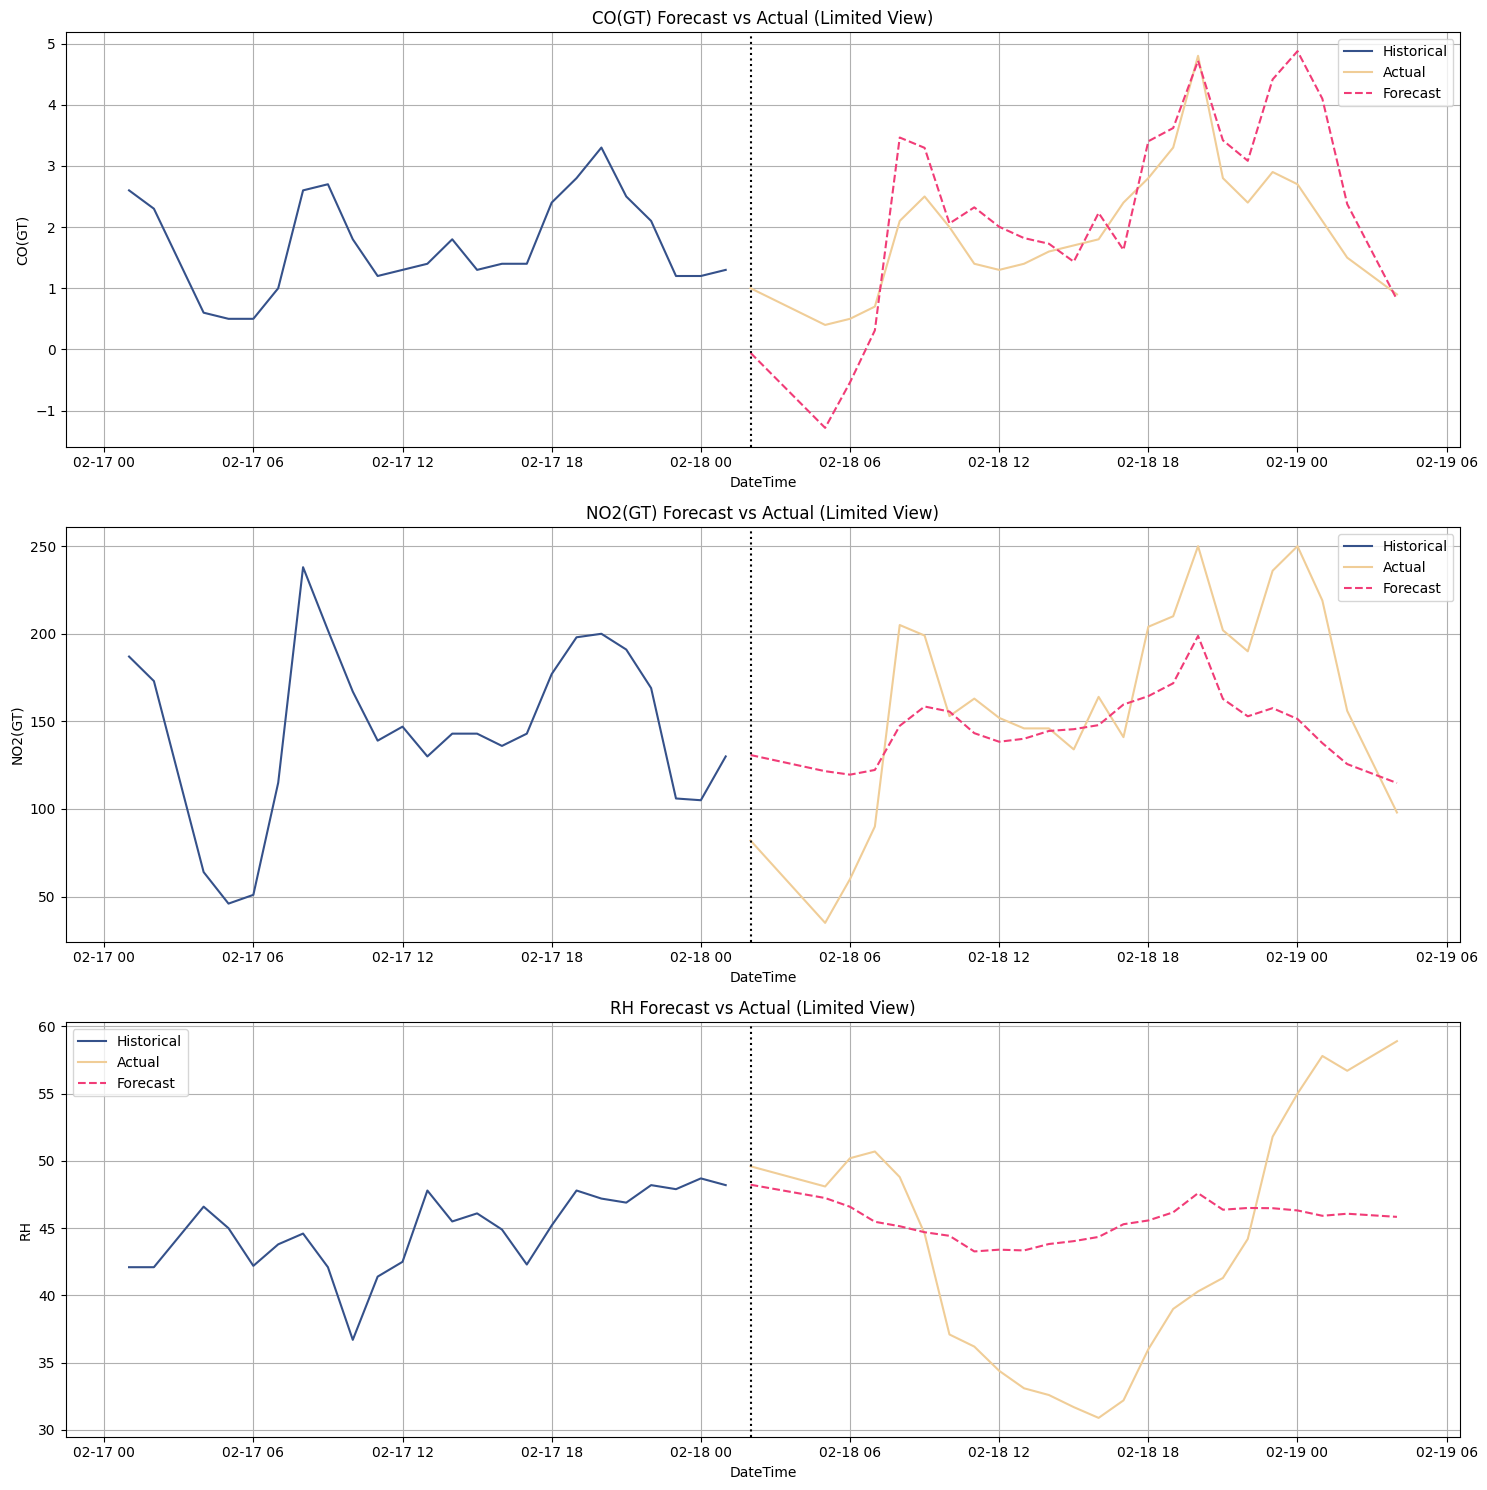

In [ ]:
# number of points to plot
num_points = 24

# Plot results
fig, axes = plt.subplots(nrows=len(target_vars), ncols=1, figsize=(15, 5 * len(target_vars)))

variables = ['CO(GT)', 'NO2(GT)', 'RH']

for i, var in enumerate(variables):
    if var not in forecasts:
        print(f"Skipping plotting for {var}: Forecast not available.")
        continue

    try:
        # Historical data (last `num_points` before test set)
        hist_start_idx = -(len(test_scaled) + num_points)
        hist_end_idx = -len(test_scaled)
        historical_data = df[var].iloc[hist_start_idx:hist_end_idx]

        # Actual test data (first `num_points` of test set)
        actual_data = test[var].iloc[:num_points]

        # Forecasted data (first `num_points` of forecast)
        forecast_data = forecasts[var][:num_points]

        # Plot historical data
        axes[i].plot(
            historical_data.index,
            scalers[var].inverse_transform(historical_data.values.reshape(-1, 1)).flatten(),
            label='Historical',
            color='#35518A'
        )

        # Plot actual test data
        axes[i].plot(
            test.index[:num_points],
            actual_data.values,
            label='Actual',
            color='#F0CD97'
        )

        # Plot forecasted data
        axes[i].plot(
            test.index[:num_points],
            forecast_data,
            label='Forecast',
            color='#F13C77',
            linestyle='--'
        )

        # Vertical line to indicate the transition from historical to test
        axes[i].axvline(x=test.index[0], color='black', linestyle=':')

        # Set titles and labels
        axes[i].set_title(f'{var} Forecast vs Actual (Limited View)')
        axes[i].set_xlabel('DateTime')
        axes[i].set_ylabel(var)
        axes[i].legend()
        axes[i].grid(True)
    except Exception as e:
        print(f"Error plotting {var}: {e}")

plt.tight_layout()
plt.show()


# ===============================
# 7. Evaluation Analysis
# ===============================

In [50]:
print("Evaluation Metrics:")
for var in target_vars:
    print(f"{var} - RMSE: {metrics[var]['RMSE']:.4f}, MAE: {metrics[var]['MAE']:.4f}")


Evaluation Metrics:
CO(GT) - RMSE: 1.2144, MAE: 1.0202
NO2(GT) - RMSE: 45.8254, MAE: 36.9386
RH - RMSE: 18.5715, MAE: 15.4967


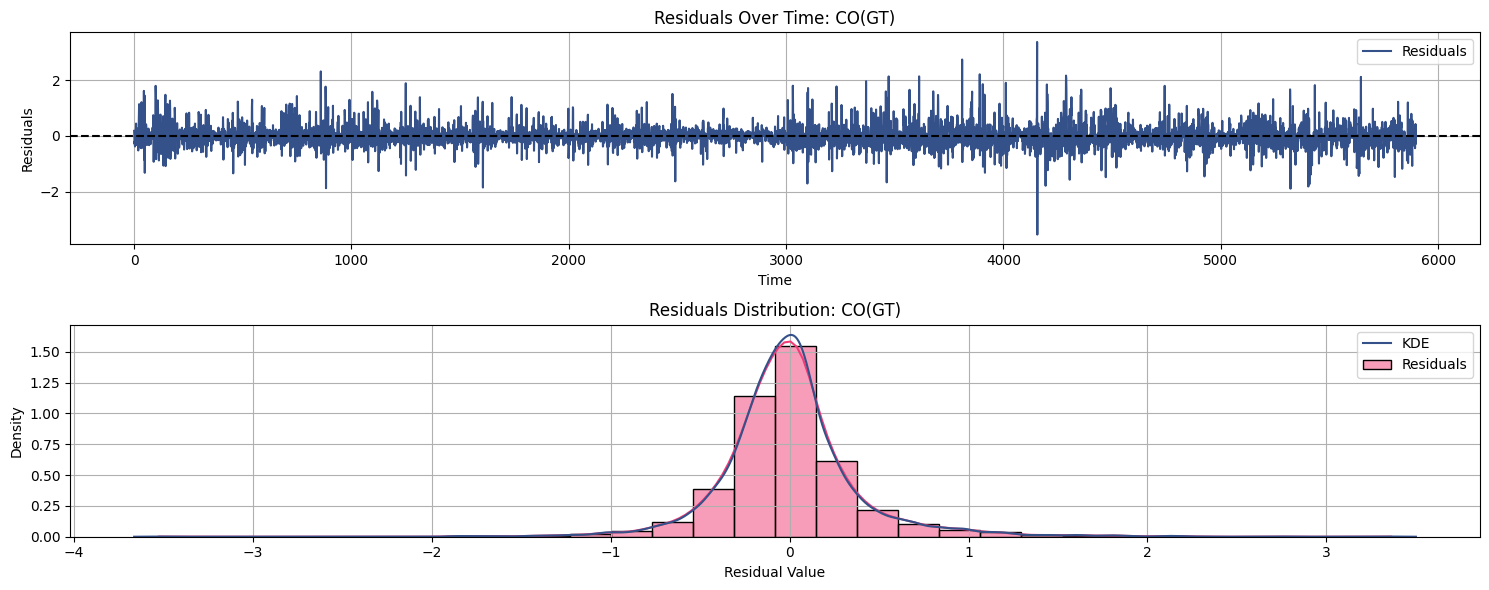

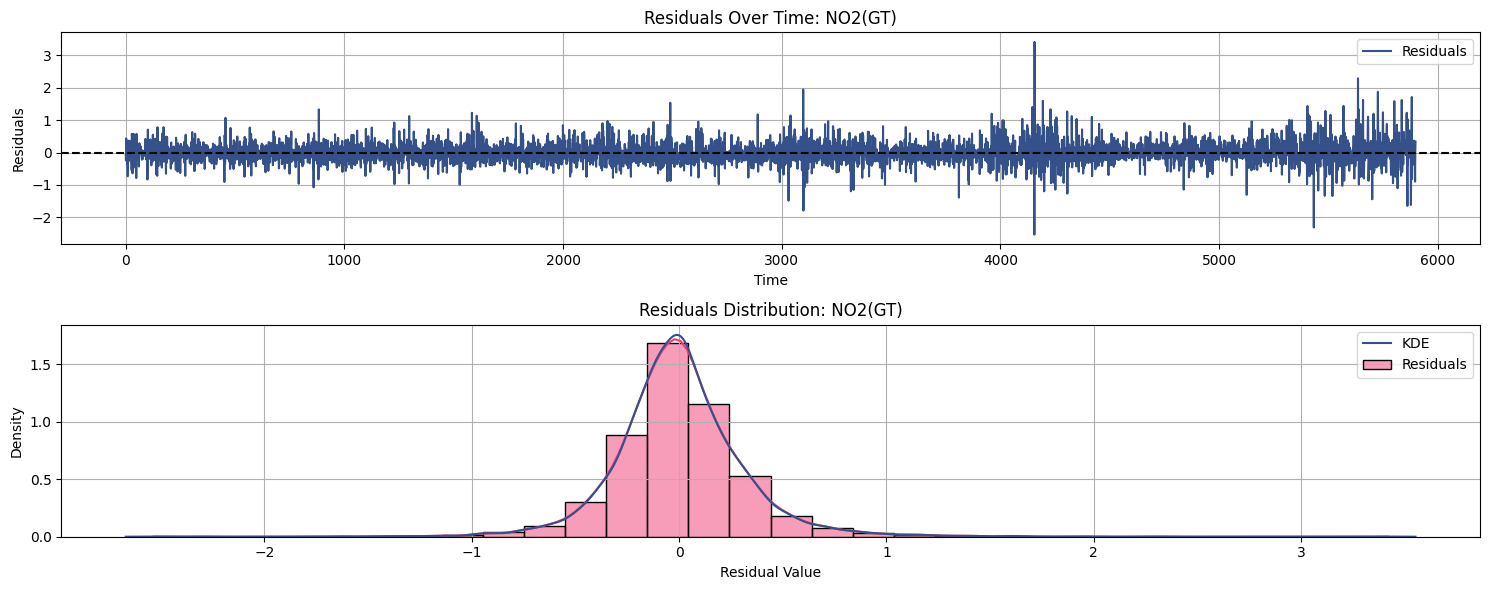

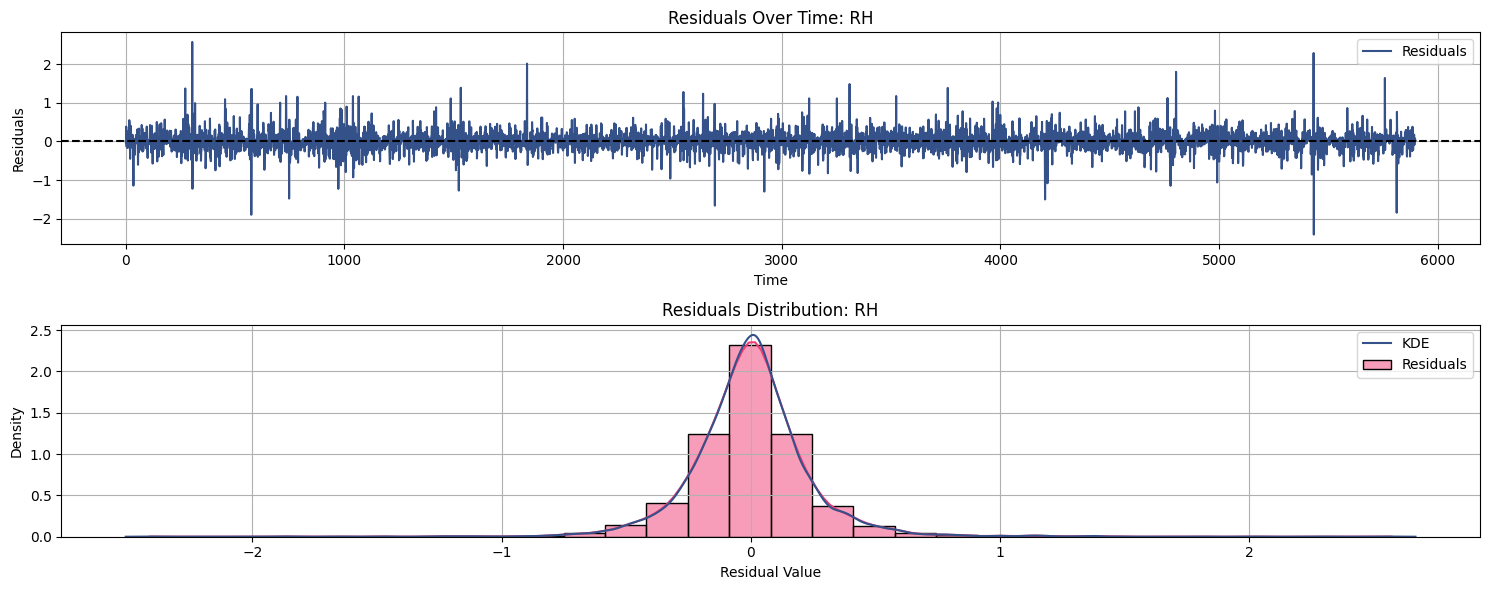

In [51]:
# Checking white noice distribution
import statsmodels.api as sm

def plot_residuals(model_fit, variable, scaler):
    residuals = model_fit.resid
    
    # Inverse transform residuals
    residuals_inv = (residuals.values.reshape(-1, 1)).flatten()
    
    # Plot Residuals Over Time
    plt.figure(figsize=(15, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(residuals_inv, label='Residuals', color='#35518A')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title(f'Residuals Over Time: {variable}')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.grid(True)
    
    # Plot Residuals Distribution
    plt.subplot(2, 1, 2)
    sns.histplot(residuals_inv, kde=True, bins=30, stat='density', label='Residuals', color='#F13C77')
    residuals_kde = sm.nonparametric.KDEUnivariate(residuals_inv)
    residuals_kde.fit()
    plt.plot(residuals_kde.support, residuals_kde.density, label='KDE', color='#35518A')
    plt.title(f'Residuals Distribution: {variable}')
    plt.xlabel('Residual Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

for var in target_vars:
    plot_residuals(models[var], var, scalers[var])


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

# residuals diagnostic
for var in target_vars:
    residuals = models[var].resid

    # Ljung-Box Test for autocorrelation
    lb_test = acorr_ljungbox(residuals, lags=[1], return_df=True)
    print(f"Ljung-Box Test for {var}:")
    print(lb_test)

    # Shapiro-Wilk Test for normality
    shapiro_test = shapiro(residuals)
    print(f"Shapiro-Wilk Test for {var}: p-value = {shapiro_test.pvalue:.64f}\n")


Ljung-Box Test for CO(GT):
    lb_stat  lb_pvalue
1  0.000827    0.97706
Shapiro-Wilk Test for CO(GT): p-value = 0.0000000000000000000000000000000000000000000000000256917693508692

Ljung-Box Test for NO2(GT):
    lb_stat  lb_pvalue
1  0.101757   0.749731
Shapiro-Wilk Test for NO2(GT): p-value = 0.0000000000000000000000000000000000000000001030779951222382445760

Ljung-Box Test for RH:
     lb_stat  lb_pvalue
1  12.575958   0.000391
Shapiro-Wilk Test for RH: p-value = 0.0000000000000000000000000000000000000000000000000024421849530586



# ===============================
# 8. Rolling Statistics
# ===============================

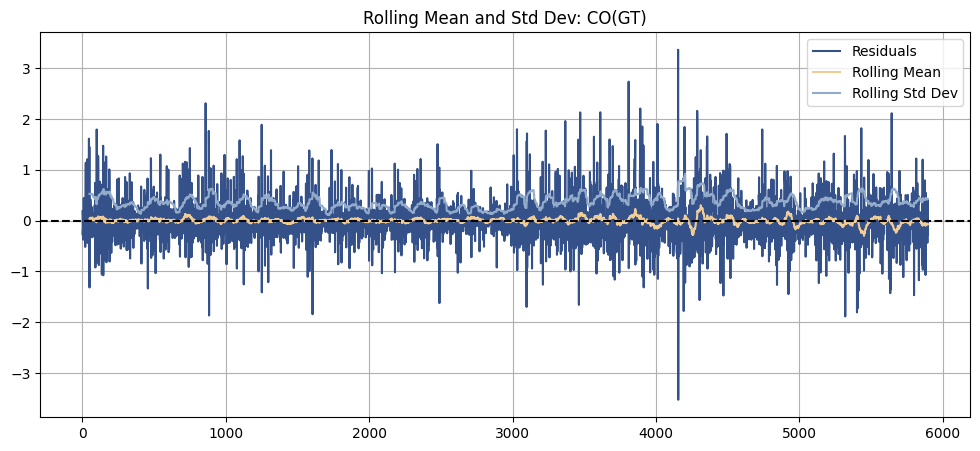

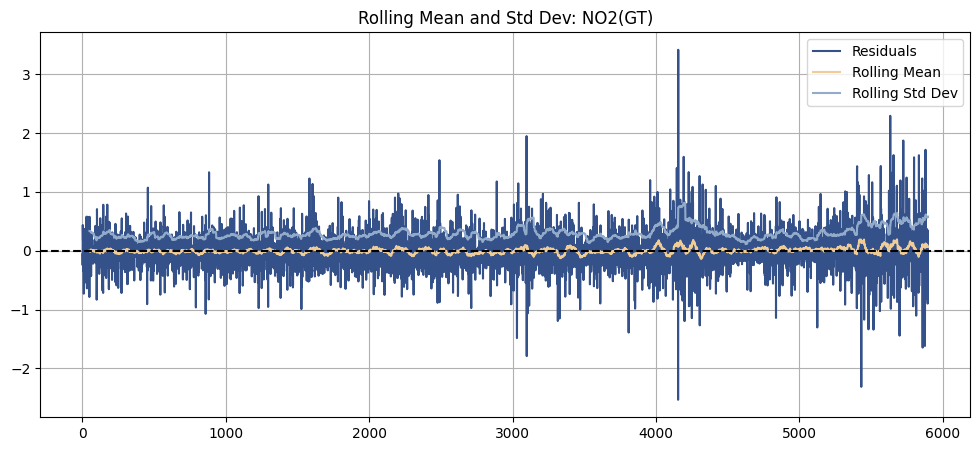

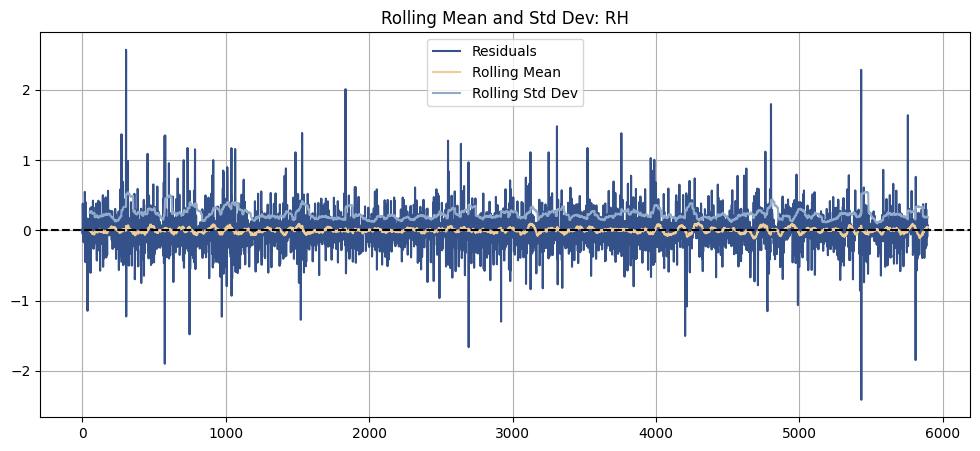

In [53]:
for var in target_vars:
    residuals = models[var].resid
    residuals_inv = scalers[var].inverse_transform(residuals.values.reshape(-1, 1)).flatten()
    rolling_mean = pd.Series(residuals_inv).rolling(window=50).mean()
    rolling_std = pd.Series(residuals_inv).rolling(window=50).std()

    plt.figure(figsize=(12, 5))
    plt.plot(residuals_inv, label='Residuals', color='#35518A')
    plt.plot(rolling_mean, label='Rolling Mean', color='#F0CD97')
    plt.plot(rolling_std, label='Rolling Std Dev', color='#93ABCA')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title(f'Rolling Mean and Std Dev: {var}')
    plt.legend()
    plt.grid(True)
    plt.show()
